In [38]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from basic_functions import *
from cmb import *
from flat_map import *

# Read the radio galaxy catalog

In [2]:
# path = "./input/sehgal_radio_catalog/radio_short.cat"
path = "./input/sehgal_radio_catalog/radio.cat"

#!!!! Just to make debugging quick, remove for final run!
nObjMax = np.int(1.e7)

data = np.genfromtxt(path)#, max_rows=nObjMax)
ra = data[:,0]  # [deg]
dec = data[:,1]  # [deg]
z = data[:,2]
# f1_4_mJy = data[:,3]  # flux in mJy 
# f30_mJy = data[:,4]  # flux in mJy 
# f90_mJy = data[:,5]  # flux in mJy 
f148_mJy = data[:,6]  # flux in mJy 
# f219_mJy = data[:,7]  # flux in mJy 
# f277_mJy = data[:,8]  # flux in mJy 
# f350_mJy = data[:,9]  # flux in mJy 

## Check the location of the sources

It is known that the Sehgal sims only have one quadrant.

Weirdly, they are not quite exactly confined in the quadrant: some objects are slightly outside:

In [86]:
print np.min(ra), np.max(ra)
print np.min(dec), np.max(dec)

-2.442386 91.996857
-0.030632 89.968413


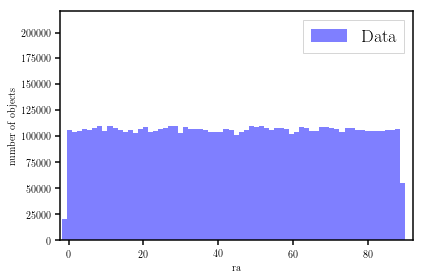

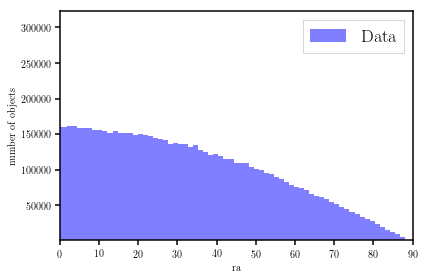

In [87]:
myHistogram(ra, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'ra', semilogx=False, semilogy=False, doGauss=False)
myHistogram(dec, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'ra', semilogx=False, semilogy=False, doGauss=False)

Throw out the objects outside of the quadrant

In [94]:
I = np.where((ra>=0.)*(ra<=90.)*(dec>=0.)*(dec<=90.))[0]
print "keeping", len(I), "objects out of", len(ra)
print "ie a fraction", 1.*len(I)/len(ra)

keeping 7107743 objects out of 7108151
ie a fraction 0.999942601107


In [95]:
ra = ra[I]
dec = dec[I]
z = z[I]
f148_mJy = f148_mJy[I]

## Check dn/dz of radio sources

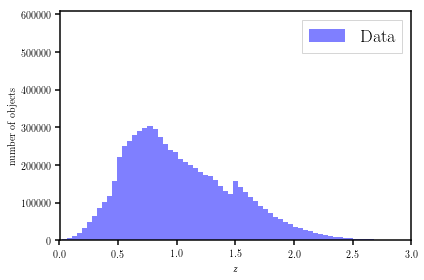

In [96]:
myHistogram(z, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'$z$', semilogx=False, semilogy=False, doGauss=False)


## Check flux distribution

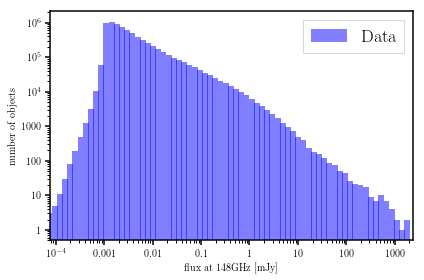

In [97]:
myHistogram(f148_mJy, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'flux at 148GHz [mJy]', semilogx=True, semilogy=True, doGauss=False)


# Generate healpy T, Q, U maps

In [98]:
# Map geometry to match the Sehgal maps
nSide = 1024 #512#4096
nPix = hp.nside2npix(nSide)

# get pixel indices for all galaxies
IPix = hp.ang2pix(nSide, np.pi - dec*np.pi/180., -ra*np.pi/180., lonlat=False)

In [99]:
print np.min(IPix), np.max(IPix)
print nPix

6292936 12582911
12582912


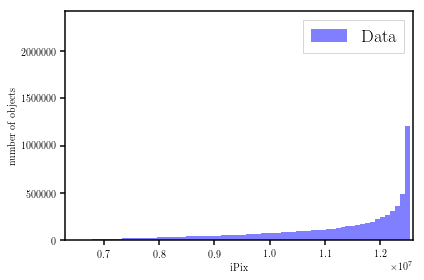

In [100]:
myHistogram(IPix, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'iPix', semilogx=False, semilogy=False, doGauss=False)

In [101]:
# Generate count map
bins = np.arange(nPix+1)-0.5
countMap, binEdges, binIndices = stats.binned_statistic(IPix, f148_mJy, statistic='count', bins=bins)

In [102]:
print "check I have all objects", np.sum(countMap), len(ra)
print "check mean number per pixel", np.mean(countMap), 1. * len(ra) / nPix

print "check min / max number of objects per pixel", np.min(countMap), np.max(countMap)

check I have all objects 7107743.0 7107743
check mean number per pixel 0.564872662226359 0.564872662226
check min / max number of objects per pixel 0.0 8301.0


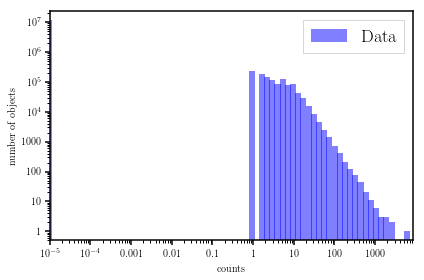

In [103]:
myHistogram(1.e-5 + countMap, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'counts', semilogx=True, semilogy=True, doGauss=False)

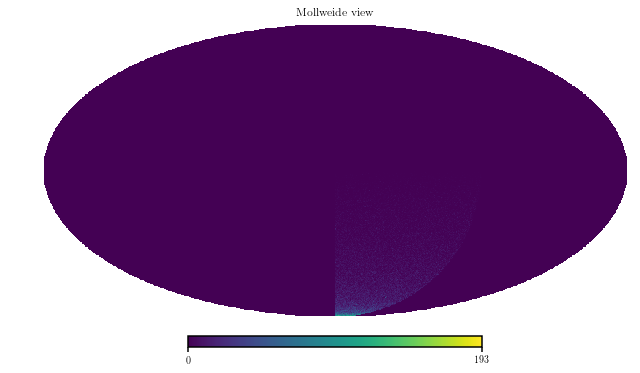

In [104]:
hp.mollview(countMap)

In [105]:
# Generate T map
bins = np.arange(nPix+1)-0.5
tMap, binEdges, binIndices = stats.binned_statistic(IPix, f148_mJy, statistic='sum', bins=bins)

In [110]:
print "check that I have all the flux", np.sum(tMap), np.sum(f148_mJy)
print "ratio is", np.sum(tMap) / np.sum(f148_mJy)

check that I have all the flux 273727.3686077693 273727.3686077691
ratio is 1.0000000000000009


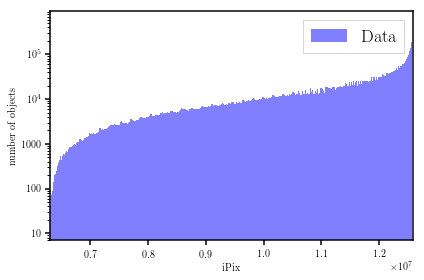

In [112]:
myHistogram(binIndices, nBins=501, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'iPix', semilogx=False, semilogy=True, doGauss=False)

In [113]:
# polarization fraction: 3% from Trombetti+18 (to be improved)
alpha = 0.03
# polarization angles:
theta = np.random.uniform(low=0., high=np.pi, size=len(ra))

# Generate Q and U maps
bins = np.arange(nPix+1)-0.5
qMap, binEdges, binIndices = stats.binned_statistic(IPix, f148_mJy * alpha * np.cos(2.*theta), statistic='sum', bins=bins)
uMap, binEdges, binIndices = stats.binned_statistic(IPix, f148_mJy * alpha * np.sin(2.*theta), statistic='sum', bins=bins)

## Convert from mJy to Kcmb

In [156]:
cmb = CMB(beam=1., noise=1., nu1=148.e9, nu2=148.e9, lMin=30., lMaxT=3.e3, lMaxP=5.e3, fg=True, atm=False, name=None)

tMap *= 1.e-3 * 1.e-26  # convert from [mJy] to flux per unit freq = [W/m^2/Hz]
tMap /= hp.nside2pixarea(nSide) # convert from flux per unit freq=[W/m^2/Hz] to surf bright per unit freq = [W/m^2/sr/Hz]
tMap /= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from surf bright per unit freq = [W/m^2/sr/Hz] to Kcmb
tMap *= 1.e6  # convert from Kcmb to muKcmb


qMap *= 1.e-3 * 1.e-26  # convert from [mJy] to flux per unit freq = [W/m^2/Hz]
qMap /= hp.nside2pixarea(nSide) # convert from flux per unit freq=[W/m^2/Hz] to surf bright per unit freq = [W/m^2/sr/Hz]
qMap /= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from surf bright per unit freq = [W/m^2/sr/Hz] to Kcmb
qMap *= 1.e6  # convert from Kcmb to muKcmb

uMap *= 1.e-3 * 1.e-26  # convert from [mJy] to flux per unit freq = [W/m^2/Hz]
uMap /= hp.nside2pixarea(nSide) # convert from flux per unit freq=[W/m^2/Hz] to surf bright per unit freq = [W/m^2/sr/Hz]
uMap /= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from surf bright per unit freq = [W/m^2/sr/Hz] to Kcmb
uMap *= 1.e6  # convert from Kcmb to muKcmb


# The Lambda website says:
# dT = [Jy/sr] * T_CMB / 1.072480e9 in [T_CMB units]
# Check that it works:
print "My conversion agrees with Lambda!", 1.e-26 / cmb.dBdT(148.e9, cmb.Tcmb), cmb.Tcmb / 1.072480e9

My conversion agrees with Lambda! 2.549291077334155e-09 2.54177234074e-09


0.0 0.14174851102290228 15158.789024106103 11.128216077707256


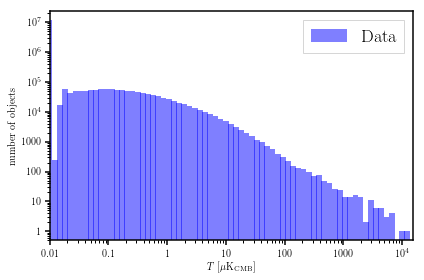

In [157]:
print np.min(tMap), np.mean(tMap), np.max(tMap), np.std(tMap)
myHistogram(1.e-2+tMap, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'$T$ [$\mu$K$_\text{CMB}$]', semilogx=True, semilogy=True, doGauss=False)


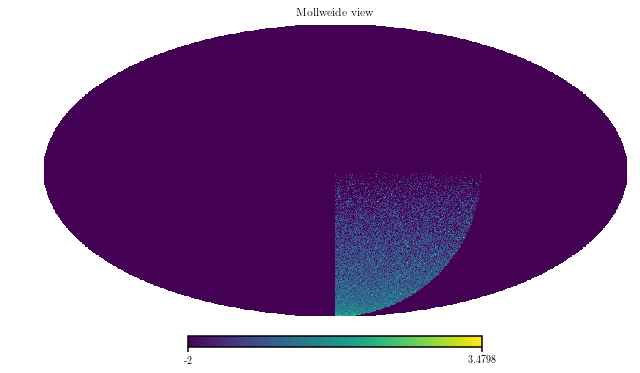

In [158]:
m = np.mean(tMap)
s = np.std(tMap)
hp.mollview(np.log10(1.e-2+tMap))#, min=1., max=1.e2)

## Rotate from equatorial to Galactic coordinates

In [159]:
# rot = hp.Rotator(coord=['C','G'])
# tMap = rot.rotate_map_pixel(tMap)

# Compare T map to Sehgal radio PS map

# Compare power with Dunkley+13

In [160]:
# Binned power spectrum wrapper for healpy

def powerSpectrum(hMap, mask=None, theory=[], fsCl=None, nBins=51, lRange=None, plot=False, path="./figures/tests/test_power.pdf", save=True):
   """Compute the power spectrum of a healpix map.
   """
   
   nSide = hp.get_nside(hMap)
   if mask is not None:
      hMap *= mask

   # define ell bins
   lMax = 3 * nSide - 1
   if lRange is None:
      lEdges = np.logspace(np.log10(1.), np.log10(lMax), nBins, 10.)
   else:
      lEdges = np.logspace(np.log10(lRange[0]), np.log10(lRange[-1]), nBins, 10.)

   # Unbinned power spectrum
   power = hp.anafast(hMap)
   power = np.nan_to_num(power)

   # corresponding ell values
   ell = np.arange(len(power))

   # Bin the power spectrum
   Cl, lEdges, binIndices = stats.binned_statistic(ell, power, statistic='mean', bins=lEdges)
   
   # correct for fsky from the mask
   if mask is not None:
      fsky = np.sum(mask) / len(mask)
      Cl /= fsky

   # bin centers
   lCen, lEdges, binIndices = stats.binned_statistic(ell, ell, statistic='mean', bins=lEdges)
   # when bin is empty, replace lCen by a naive expectation
   lCenNaive = 0.5*(lEdges[:-1]+lEdges[1:])
   lCen[np.where(np.isnan(lCen))] = lCenNaive[np.where(np.isnan(lCen))]
   # number of modes
   Nmodes, lEdges, binIndices = stats.binned_statistic(ell, 2*ell+1, statistic='sum', bins=lEdges)
   Nmodes = np.nan_to_num(Nmodes)

   # 1sigma uncertainty on Cl
   if fsCl is None:
      sCl = Cl*np.sqrt(2)
   else:
      sCl = np.array(map(fsCl, lCen))
   sCl /= np.sqrt(Nmodes)
   sCl = np.nan_to_num(sCl)

   if plot:
      factor = lCen**2  # 1.
      
      fig=plt.figure(0)
      ax=fig.add_subplot(111)
      #
      ax.errorbar(lCen, factor*Cl, yerr=factor* sCl, c='b', fmt='.')
      ax.errorbar(lCen, -factor*Cl, yerr=factor* sCl, c='r', fmt='.')
      #
      for f in theory:
         L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
         ClExpected = np.array(map(f, L))
         ax.plot(L, L**2 * ClExpected, 'k')
      #
      ax.set_xscale('log', nonposx='clip')
      ax.set_yscale('log', nonposy='clip')
      #ax.set_xlim(1.e1, 4.e4)
      #ax.set_ylim(1.e-5, 2.e5)
      ax.set_xlabel(r'$\ell$')
      #ax.set_ylabel(r'$\ell^2 C_\ell$')
      ax.set_ylabel(r'$\ell^2 C_\ell$')
      #
      if save==True:
         print "saving plot to "+path
         fig.savefig(path, bbox_inches='tight')
#          fig.clf()
      else:
         plt.show()

   return lCen, Cl, sCl

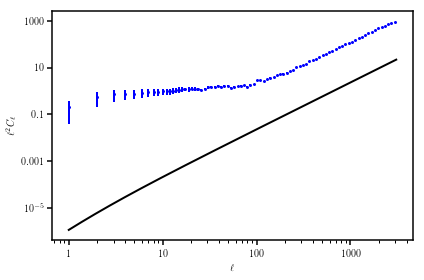

In [161]:
lCen, Cl, sCl = powerSpectrum(tMap, mask=None, theory=[cmb.fradioPoisson], fsCl=None, nBins=101, lRange=None, plot=True, path="", save=False)


In [162]:
cl = hp.anafast(tMap)

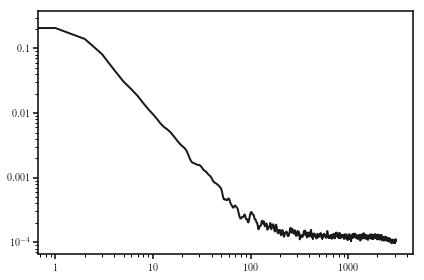

In [163]:
plt.loglog(np.arange(len(cl)), cl)
# plt.loglog(hp.pixwin(nSide))
plt.show()

# Extract cutouts

In [164]:
# position (lon, lat, psi) of the cutout center
lon = -45. # [deg]
lat = -45. # [deg]
pos = (lon, lat, 0.) 

# map side in lon and lat
dLon = 10.# [deg]
dLat = 10.# [deg]
lonRange = (-dLon/2., dLon/2.) # [deg]
latRange = (-dLat/2., dLat/2.) # [deg]
pixRes = 0.5 / 60.  # [arcmin] to [deg]

# number of pixels on the side
xSize = np.int(np.ceil(dLon / pixRes))
ySize = np.int(np.ceil(dLat / pixRes))

baseMap = FlatMap(nX=xSize, nY=ySize, sizeX=dLon*np.pi/180., sizeY=dLat*np.pi/180.)

number of objects in cutout [[4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]
 ...
 [2. 5. 5. ... 5. 5. 2.]
 [2. 2. 5. ... 5. 2. 2.]
 [2. 2. 5. ... 5. 2. 2.]]


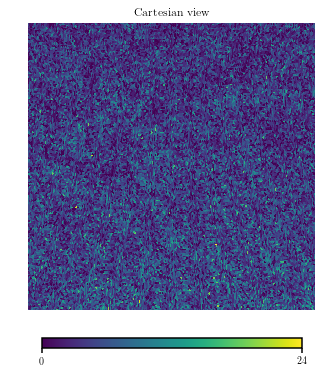

In [165]:
# Count map
cutCountMap = hp.visufunc.cartview(countMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True)
print "number of objects in cutout", cutCountMap

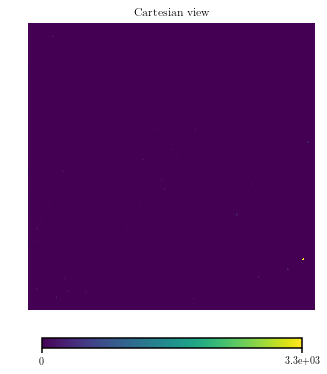

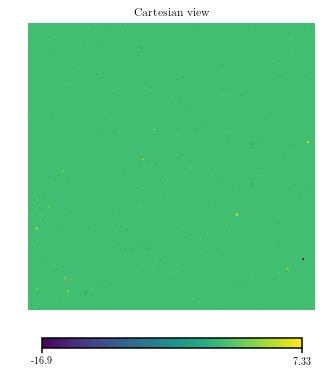

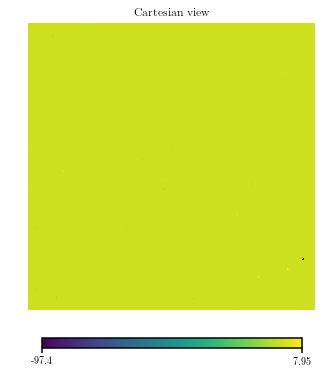

In [166]:
# T map
cutTMap = hp.visufunc.cartview(tMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True)
# Q map
cutTMap = hp.visufunc.cartview(qMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True)
# U map
cutTMap = hp.visufunc.cartview(uMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True)


# Check their power spectra

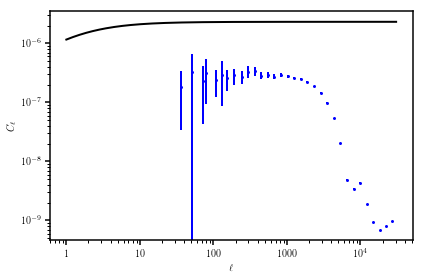

(array([1.11470873e+00, 1.37044237e+00, 1.68484577e+00, 2.07137880e+00,
        2.54658925e+00, 3.13082128e+00, 3.84908633e+00, 4.73213392e+00,
        5.81776804e+00, 7.15246558e+00, 8.79336603e+00, 1.08107177e+01,
        1.32908850e+01, 1.63400461e+01, 2.00887378e+01, 2.46974450e+01,
        3.03634699e+01, 3.60000000e+01, 4.58933913e+01, 5.09116882e+01,
        7.20000000e+01, 8.04984472e+01, 1.09223860e+02, 1.29799846e+02,
        1.51937301e+02, 1.91270149e+02, 2.41465841e+02, 2.98367968e+02,
        3.62562851e+02, 4.48083110e+02, 5.51018255e+02, 6.74563738e+02,
        8.30185858e+02, 1.02254115e+03, 1.25662127e+03, 1.54353860e+03,
        1.89580859e+03, 2.33023163e+03, 2.86609699e+03, 3.52478806e+03,
        4.33291862e+03, 5.32556018e+03, 6.54641300e+03, 8.04916276e+03,
        9.89677158e+03, 1.21670163e+04, 1.49576873e+04, 1.83891357e+04,
        2.21404303e+04, 2.66978844e+04]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00

In [167]:
cutTMapFourier = baseMap.fourier(cutTMap)
baseMap.powerSpectrum(cutTMapFourier, theory=[cmb.fradioPoisson], plot=True)

# Mask the point sources above 5mJy?